In [221]:
from augur.utils import json_to_tree
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import numpy as np
import pandas as pd
from Bio import SeqIO
from collections import Counter
import requests


Analysis of convergent evolution: 

Find every mutation observed on tree. For each mutation: find number of occurences and average number of S1 mutations (or avg logistic growth rate) of all descending clades

In [549]:
#Download tree json
tree_url = "https://data.nextstrain.org/ncov_global.json"

tree_json = requests.get(tree_url).json()

#Put tree in Bio.Phylo format
tree = json_to_tree(tree_json)

1. Find every mutation that is observed on internal branches of the tree
2. Find the number of times each mutation occurred independently
3. Keep track of which muts are reversions

In [550]:
# find root sequence, in order to exclude reversions

reference_sequence = {}

for record in SeqIO.parse(open("reference_seq_edited.gb","r"), "genbank"):
    for feature in record.features:
        if feature.type == 'CDS':
            gene_seq = feature.location.extract(record.seq).translate()
            reference_sequence[feature.qualifiers['gene'][0]] = gene_seq


/Users/katekistler/anaconda3/envs/nextstrain/lib/python3.6/site-packages/Bio/Seq.py:2859: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning,


In [551]:
all_mutations = []

reversions = []


#only look at mutations on internal branches
for node in tree.find_clades(terminal=False):

    # look just at nonsyn muts
    if hasattr(node, 'branch_attrs'):
        for gene, mut_list in node.branch_attrs["mutations"].items():
            if gene!= 'nuc':
                for mut in mut_list:
                    gene_mutation = f'{gene}_{mut}'
                    
                    # exclude if mutation is in stop codon position of gene
                    if int(mut[1:-1])!=len(reference_sequence[gene]):
                        all_mutations.append(gene_mutation)
                    
                    # find whether mutation is a reversion
                    if reference_sequence[gene][int(mut[1:-1])-1] == mut[-1]:
                        if gene_mutation not in reversions:
                            reversions.append(gene_mutation)
                    



all_mutations_unique = list(set(all_mutations))    

independent_occurences_all_mutations = Counter(all_mutations)


For each clade: 
1. find the number of S1 muts and the logistic growth rate
2. find all mutations that happened on path from root to clade
3. for each mutation in (2), add the values from (1) to a list. 

Over all clades, the result will be a dictionary where each observed mutation is a key and the values are the logistic growth rates of all clades that descend from the observed mutation. 

In [552]:
#Function to find path from root to clade
def get_parent(tree, child_clade):
    node_path = tree.get_path(child_clade)
    return node_path


In [553]:
#initialize dict for storing all growth rates observed in clades descending from {key} mutation
growth_by_precedingmut_dict = {k:[] for k in all_mutations_unique}


#initialize dict for storing S1 mutation counts observed in clades descending from {key} mutation
s1muts_by_precedingmut_dict = {k:[] for k in all_mutations_unique}



for node in tree.find_clades():
    node_path = get_parent(tree, node)



    if "S1_mutations" in node.node_attrs:
        s1_mutations = node.node_attrs["S1_mutations"]["value"]
    

    if "logistic_growth" in node.node_attrs:
        logistic_growth = node.node_attrs["logistic_growth"]["value"]

        
    for parent in node_path[:-1]:
        if hasattr(parent, 'branch_attrs'):
            for gene, mut_list in parent.branch_attrs["mutations"].items():
                if gene!= 'nuc':
                    for mut in mut_list:
                        gene_mutation = f'{gene}_{mut}'
                        # exclude mutations to stop codons
                        if int(mut[1:-1])!=len(reference_sequence[gene]):
           
                            if logistic_growth:
                                growth_by_precedingmut_dict[gene_mutation].append(logistic_growth)

                            if s1_mutations:
                                s1muts_by_precedingmut_dict[gene_mutation].append(s1_mutations)


                        


Find mean growth rate after mutation

In [554]:
# to consider: clade nesting-> just take unique values? 
# Here, all nested clades are averaging, giving more weight to larger clades
growth_by_precedingmut_mean = {k:(sum(v)/len(v)) for k,v in growth_by_precedingmut_dict.items()}

# Here, only unique values are taken, to limit the effect of nesting clades
growth_by_precedingmut_limit_nesting = {k:list(set(v)) for k,v in growth_by_precedingmut_dict.items()}
growth_by_precedingmut_limit_nesting_mean = {k:(sum(v)/len(v)) for k,v in growth_by_precedingmut_limit_nesting.items()}



Find mean number of S1 mutations in clades descending from mutation

In [555]:
# this will give more weight to larger clades
s1muts_by_precedingmut_mean = {k:(sum(v)/len(v)) for k,v in s1muts_by_precedingmut_dict.items() if len(v)!=0}


In [556]:
# make dataframe where each row is a mutation
# and columns contain number of independent occurences, average growth rates, and number of S1 mutations

convergent_evo_list = []

for mut, occurences in independent_occurences_all_mutations.items():
    if mut in s1muts_by_precedingmut_mean.keys():
        avg_s1_muts = s1muts_by_precedingmut_mean[mut]
    else:
        avg_s1_muts = None
    
    if mut in growth_by_precedingmut_mean.keys():
        avg_growth = growth_by_precedingmut_mean[mut]
    else:
        avg_growth = None

    if mut in growth_by_precedingmut_limit_nesting_mean.keys():
        avg_growth_limited = growth_by_precedingmut_limit_nesting_mean[mut]
    else:
        avg_growth_limited = None
    
    if mut in reversions:
        reversion = True
    else:
        reversion = False
        
    # for deletions that span multiple consecutive residues, condense this into one row
    if mut == 'ORF1a_S3675-': 
        mut = 'ORF1a_3675/3676/3677del'

    
    elif mut == 'S_H69-':
        mut = 'S_69/70del'
        
    if mut not in ['ORF1a_G3676-', 'ORF1a_F3677-', 'S_V70-']:
        convergent_evo_list.append({'mutation': mut, 'independent_occurences': occurences, 
                                    'avg_s1_muts': avg_s1_muts, 'avg_growth': avg_growth, 
                                    'avg_growth_limited': avg_growth_limited, 'reversion': reversion})

convergent_evo_df = pd.DataFrame(convergent_evo_list)

convergent_evo_df_no_reversion = convergent_evo_df.copy()
convergent_evo_df_no_reversion = convergent_evo_df_no_reversion[convergent_evo_df_no_reversion['reversion']==False].reset_index()

# multiply occurrences times growth
convergent_evo_df_no_reversion['occurences_times_growth']= convergent_evo_df_no_reversion['independent_occurences']*convergent_evo_df_no_reversion['avg_growth']
convergent_evo_df_no_reversion['occurences_times_growth_limited']= convergent_evo_df_no_reversion['independent_occurences']*convergent_evo_df_no_reversion['avg_growth_limited']




Plot the number of independent occurences versus mean logisitic growth rate of descending clades

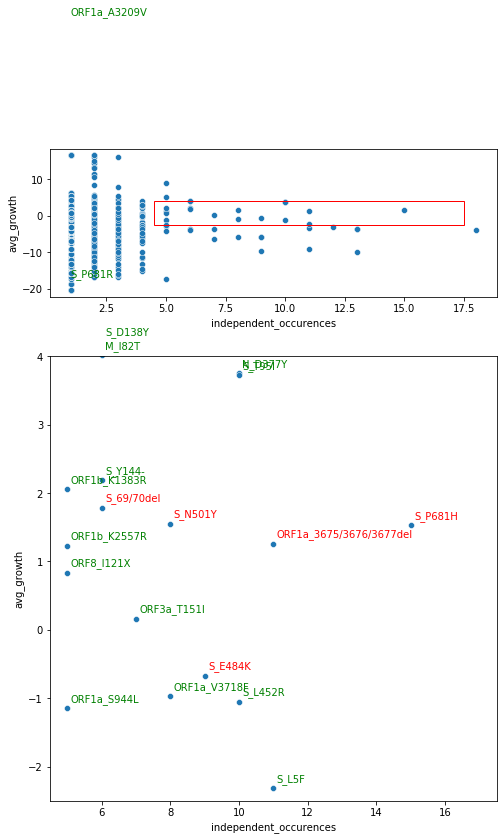

In [557]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,12), gridspec_kw={'height_ratios': [1, 3]})
sns.scatterplot(x='independent_occurences', y='avg_growth', 
                data=convergent_evo_df_no_reversion, ax=ax1)
sns.scatterplot(x='independent_occurences', y='avg_growth', 
                data=convergent_evo_df_no_reversion, ax=ax2)

ax2.set_ylim(-2.5, 4.0)
ax2.set_xlim(4.5, 17.5)

ax1.add_patch(
    patches.Rectangle(
        xy=(4.5, -2.5),  # point of origin.
        width=13,
        height=6.5,
        linewidth=1,
        color='red',
        fill=False
    )
)




label_muts = ['S_N501Y', 'S_E484K', 'ORF1a_3675/3676/3677del', 'S_69/70del', 'S_P681H']

for i in range(convergent_evo_df_no_reversion.shape[0]):
    if convergent_evo_df_no_reversion['mutation'][i] in label_muts:
        ax2.text(x=convergent_evo_df_no_reversion.independent_occurences[i]+0.1,y=convergent_evo_df_no_reversion.avg_growth[i]+0.1,
                 s=convergent_evo_df_no_reversion.mutation[i], fontdict=dict(color='red',size=10))
    else:
        if convergent_evo_df_no_reversion.avg_growth[i]>= -2.5:
            if convergent_evo_df_no_reversion.independent_occurences[i]>=4.5:
                ax2.text(x=convergent_evo_df_no_reversion.independent_occurences[i]+0.1,y=convergent_evo_df_no_reversion.avg_growth[i]+0.1,
                         s=convergent_evo_df_no_reversion.mutation[i], fontdict=dict(color='green',size=10))

Plot the number of independent occurences versus mean logisitic growth rate (limited) of descending clades. Limited growth rate is psuedo-way of limiting clade nesting by taking the average of unique growth rate values (assuming that unique values are shared only by clades and, thus, this method will average over clades of at least 5 tips)

In [558]:
len(convergent_evo_df_no_reversion[convergent_evo_df_no_reversion['independent_occurences']>=5])/len(convergent_evo_df_no_reversion)

0.023853211009174313

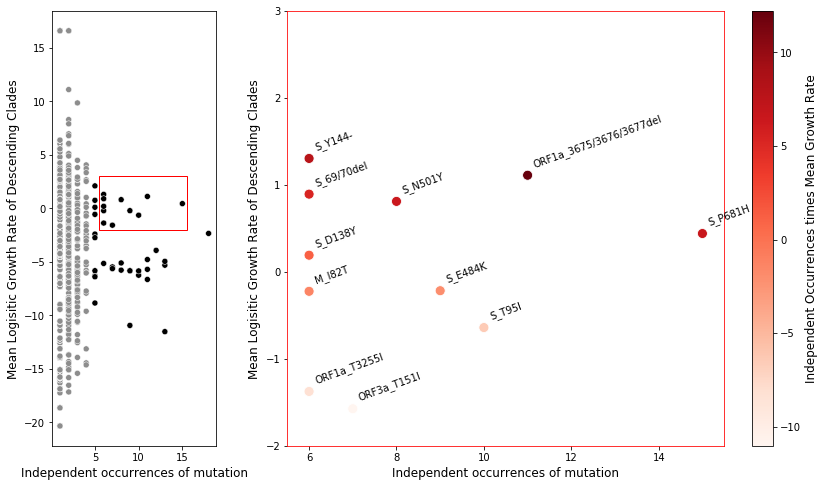

In [579]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,8), gridspec_kw={'width_ratios': [1.5, 5]})

cmap = sns.color_palette("Reds", as_cmap=True)

cmap2 = {**{x:'#8d8d8d' for x in range(0,5)}, **{y:'black' for y in range(5,20)}}

sns.scatterplot(x='independent_occurences', y='avg_growth_limited', 
                data=convergent_evo_df_no_reversion, ax=ax1, hue='independent_occurences',
                palette = cmap2, legend = False)

convergent_evo_df_no_reversion_zoom = convergent_evo_df_no_reversion.loc[(convergent_evo_df_no_reversion['avg_growth_limited']>=-2.0) & (convergent_evo_df_no_reversion['independent_occurences']>=5.5)].reset_index()
sns.scatterplot(x='independent_occurences', y='avg_growth_limited', 
                data=convergent_evo_df_no_reversion_zoom, ax=ax2, s=100,
               hue = 'occurences_times_growth_limited', palette=cmap)

norm = plt.Normalize(convergent_evo_df_no_reversion_zoom['occurences_times_growth_limited'].min(), convergent_evo_df_no_reversion_zoom['occurences_times_growth_limited'].max())
sm = plt.cm.ScalarMappable(cmap="Reds", norm=norm)
sm.set_array([])


ax1.set_xlabel('Independent occurrences of mutation', fontsize = 12)
ax1.set_ylabel('Mean Logisitic Growth Rate of Descending Clades', fontsize = 12)

ax2.set_ylim(-2.0, 3.0)
ax2.set_xlim(5.5, 15.5)
ax2.set_xlabel('Independent occurrences of mutation', fontsize = 12)
ax2.set_ylabel('Mean Logisitic Growth Rate of Descending Clades', fontsize = 12)

ax1.add_patch(
    patches.Rectangle(
        xy=(5.5, -2.0),  # point of origin.
        width=10,
        height=5,
        linewidth=1,
        color='red',
        fill=False
    )
)

ax2.get_legend().remove()
ax2.figure.colorbar(sm, label='Independent Occurrences times Mean Growth Rate')
ax2.figure.axes[-1].yaxis.label.set_size(12)

# handles, labels = ax2.get_legend_handles_labels()
# lgd = ax2.legend(handles[::-1], labels[::-1], loc='upper center', bbox_to_anchor=(1.2, 1.0), title='Occurrences times Growth Rate')

ax2.spines['bottom'].set_color('red')
ax2.spines['top'].set_color('red')
ax2.spines['left'].set_color('red')
ax2.spines['right'].set_color('red')



# initialize list of mutations identified this way
top_scoring_muts = []

for i in range(convergent_evo_df_no_reversion_zoom.shape[0]):
    ax2.text(x=convergent_evo_df_no_reversion_zoom.independent_occurences[i]+0.1,
             y=convergent_evo_df_no_reversion_zoom.avg_growth_limited[i]+0.1,
             s=convergent_evo_df_no_reversion_zoom.mutation[i], 
             fontdict=dict(color='black',size=10, rotation=20))
    top_scoring_muts.append(convergent_evo_df_no_reversion_zoom.mutation[i])

For the mutations shown in the inset, find how many emerging lineages contain this mutation at (at least) 50%

In [580]:
sequences_file = 'global_subsampled_sequences.fasta'
record_dict = SeqIO.to_dict(SeqIO.parse(sequences_file, "fasta"))


In [574]:
# read in reference file and find genome position for each codon in the top scoring sites

# find the start position of the codon encoding each site
genome_location_of_sites = {}

for mutation in top_scoring_muts:
    gene = mutation.split('_')[0]
    if mutation[-3:]!='del':
        mut_pos = mutation.split('_')[1][1:-1]
        
    elif mutation[-3:]=='del':
        mut_pos = mutation.split('_')[1].split('/')[0]

    for record in SeqIO.parse(open("reference_seq_edited.gb","r"), "genbank"):
        for feature in record.features:
            if feature.type == 'CDS':
                if feature.qualifiers['gene'][0] == gene:
                    mut_location_start = feature.location.start + (((int(mut_pos)-1)*3)+1)
#                     print((record.seq[mut_location_start:mut_location_start+3]).translate())
                    genome_location_of_sites[mut_location_start] = mutation
    


In [575]:
# initialize dictionary to store genotype info
tip_genotypes = {}

for k,v in record_dict.items():
    this_tip = {}
    # store genotype at each mutation site
    for nt_start, mutation in genome_location_of_sites.items():
        
        nt_codon = v.seq[nt_start-1:nt_start+2]
        if all([characters in ['A', 'C', 'G', 'T'] for characters in nt_codon]):
            this_tip[mutation] = str(nt_codon.translate())
        elif all([characters in ['-'] for characters in nt_codon]):
            this_tip[mutation] = '-'
        else:
            this_tip[mutation] = None

    tip_genotypes[k] = this_tip

In [576]:
#initiate list to store all clade info
clade_stats = []

emerging_lineage_tips = {}

# don't want to double count, so only look at base of emerging lineage clade
clade_bases = []

for node in tree.find_clades(terminal=False):
    
    if "emerging_lineage" in node.node_attrs:
        emerging_lineage = node.node_attrs["emerging_lineage"]["value"]
        
        if emerging_lineage!='unassigned':
        
            clade_already_visited = False

            node_path = get_parent(tree, node)
            for parent in node_path:
                if parent in clade_bases:
                    clade_already_visited = True

            if clade_already_visited == False:
    #                     print(node.__dict__)
                clade_bases.append(node)

                tips_in_clade = node.get_terminals()
                tip_names_in_clade = [t.name for t in tips_in_clade]

                # tally the number of tips with given mutation within the clade
                clade_genotype_tally = {k:0 for k in top_scoring_muts}
                clade_genotype_tally_denominator = {k:0 for k in top_scoring_muts}
                for tip in tip_names_in_clade:
                    for mutation, aa in tip_genotypes[tip].items():
                        if aa!= None:
                            clade_genotype_tally_denominator[mutation]+=1
                            if mutation[-3:] == 'del':
                                if aa == '-':
                                    clade_genotype_tally[mutation]+=1
                            if aa == mutation[-1]:
                                clade_genotype_tally[mutation]+=1
                
                            

                # find proportion of tips that have the given mutation
                clade_genotype_freqs = {}
                for k, v in clade_genotype_tally.items():
                    freq = v/clade_genotype_tally_denominator[k]

                    clade_genotype_freqs[k] = freq


                clade_stats.append({'emerging_lineage': emerging_lineage, **clade_genotype_freqs})


clade_stats_df = pd.DataFrame(clade_stats).fillna(0)

Count the number of lineages where these mutations appear at frequency 50% or higher

Text(0.5, 0, '')

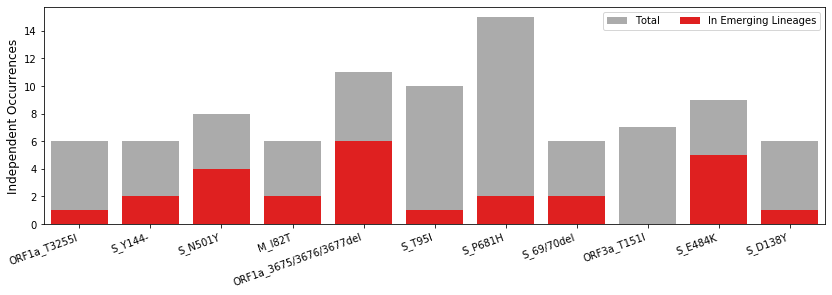

In [578]:
count_lineages_df = clade_stats_df.drop('emerging_lineage', axis=1)

mutation_emerging_lineage_counts = count_lineages_df[count_lineages_df  > 0.5].count()


number_of_occurrences_resulting_in_emerging_lineage = []
for mut, count in mutation_emerging_lineage_counts.items():
    if mut == 'ORF1a_3675/3676/3677del':
        m = 'ORF1a_S3675-'
    elif mut == 'S_69/70del':
        m = 'S_H69-'
    else:
        m = mut

    independent_occurrences = independent_occurences_all_mutations[m]
    number_of_occurrences_resulting_in_emerging_lineage.append({'mutation':mut, 'num_emerging_lineages': count,
                                                                'independent_occurrences':independent_occurrences,
                                                               'fraction_emerging': count/independent_occurrences})

plot_emerging_lineages = pd.DataFrame(number_of_occurrences_resulting_in_emerging_lineage)

f, ax = plt.subplots(figsize=(14, 4))
sns.barplot(x="mutation", y="independent_occurrences", data=plot_emerging_lineages,
            label="Total", color='#ABABAB')

sns.barplot(x="mutation", y="num_emerging_lineages", data=plot_emerging_lineages,
            label="In Emerging Lineages", color="r")
ax.legend(ncol=2, loc="upper right", frameon=True)
plt.xticks(rotation = 20, ha='right')

ax.set_ylabel('Independent Occurrences', fontsize = 12)
ax.set_xlabel('', fontsize = 12)

In [581]:
plot_emerging_lineages

,mutation,num_emerging_lineages,independent_occurrences,fraction_emerging
0,ORF1a_T3255I,1,6,0.166667
1,S_Y144-,2,6,0.333333
2,S_N501Y,4,8,0.500000
3,M_I82T,2,6,0.333333
4,ORF1a_3675/3676/3677del,6,11,0.545455
5,S_T95I,1,10,0.100000
6,S_P681H,2,15,0.133333
7,S_69/70del,2,6,0.333333
8,ORF3a_T151I,0,7,0.000000
9,S_E484K,5,9,0.555556


Plot the number of independent times a site mutates versus logistic growth of descending clades

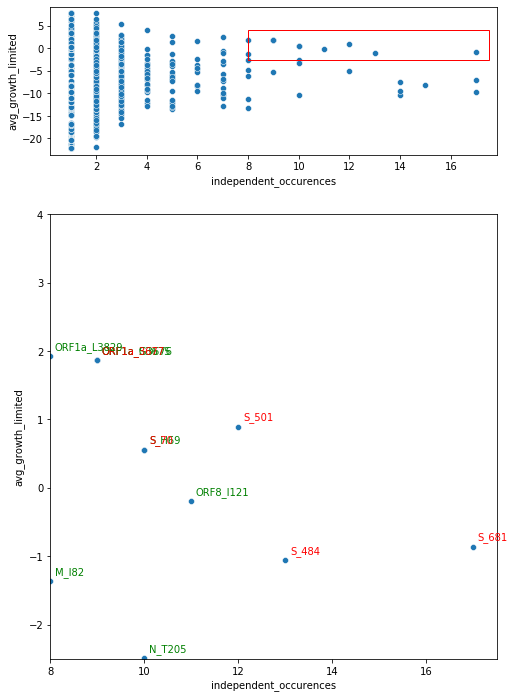

In [276]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,12), gridspec_kw={'height_ratios': [1, 3]})
sns.scatterplot(x='independent_occurences', y='avg_growth_limited', 
                data=convergent_evo_pos_df, ax=ax1)
sns.scatterplot(x='independent_occurences', y='avg_growth_limited', 
                data=convergent_evo_pos_df, ax=ax2)

ax2.set_ylim(-2.5, 4.0)
ax2.set_xlim(8, 17.5)

ax1.add_patch(
    patches.Rectangle(
        xy=(8, -2.5),  # point of origin.
        width=9.5,
        height=6.5,
        linewidth=1,
        color='red',
        fill=False
    )
)




label_muts = ['S_N501', 'S_E484', 'ORF1a_F3677', 'S_V70', 'S_P681']

for i in range(convergent_evo_pos_df.shape[0]):
    if convergent_evo_pos_df['mutation'][i] in label_muts:
        label_parts = convergent_evo_pos_df.mutation[i].split('_')
        label = f'{label_parts[0]}_{label_parts[1][1:]}'
        ax2.text(x=convergent_evo_pos_df.independent_occurences[i]+0.1,
                 y=convergent_evo_pos_df.avg_growth_limited[i]+0.1,
                 s=label, fontdict=dict(color='red',size=10))
    else:
        if convergent_evo_pos_df.avg_growth_limited[i]>= -2.5:
            if convergent_evo_pos_df.independent_occurences[i]>=8:
                ax2.text(x=convergent_evo_pos_df.independent_occurences[i]+0.1,
                         y=convergent_evo_pos_df.avg_growth_limited[i]+0.1,
                         s=convergent_evo_pos_df.mutation[i], fontdict=dict(color='green',size=10))

Plot the number of independent occurences versus average number of S1 mutations in all descending clades

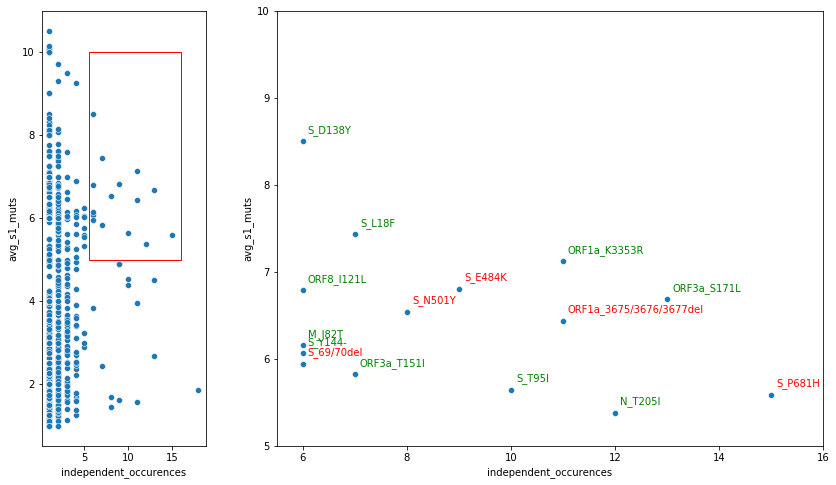

In [587]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,8), gridspec_kw={'width_ratios': [1.5, 5]})
sns.scatterplot(x='independent_occurences', y='avg_s1_muts', 
                data=convergent_evo_df_no_reversion, ax=ax1)
sns.scatterplot(x='independent_occurences', y='avg_s1_muts', 
                data=convergent_evo_df_no_reversion, ax=ax2)

ax2.set_ylim(5.0, 10)
ax2.set_xlim(5.5, 16)

ax1.add_patch(
    patches.Rectangle(
        xy=(5.5, 5.0),  # point of origin.
        width=10.5,
        height=5,
        linewidth=1,
        color='red',
        fill=False
    )
)




label_muts = ['S_N501Y', 'S_E484K', 'ORF1a_3675/3676/3677del', 'S_69/70del', 'S_P681H']

for i in range(convergent_evo_df_no_reversion.shape[0]):
    if convergent_evo_df_no_reversion['mutation'][i] in label_muts:
        ax2.text(x=convergent_evo_df_no_reversion.independent_occurences[i]+0.1,
                 y=convergent_evo_df_no_reversion.avg_s1_muts[i]+0.1,
                 s=convergent_evo_df_no_reversion.mutation[i], fontdict=dict(color='red',size=10))
    else:
        if convergent_evo_df_no_reversion.avg_s1_muts[i]>= 5.0:
            if convergent_evo_df_no_reversion.independent_occurences[i]>=5.5:
                ax2.text(x=convergent_evo_df_no_reversion.independent_occurences[i]+0.1,
                         y=convergent_evo_df_no_reversion.avg_s1_muts[i]+0.1,
                         s=convergent_evo_df_no_reversion.mutation[i], fontdict=dict(color='green',size=10))

Try multiplying occurences by rate

In [353]:
convergent_evo_df_no_reversion['occurences_times_growth']= convergent_evo_df_no_reversion['independent_occurences']*convergent_evo_df_no_reversion['avg_growth']
convergent_evo_df_no_reversion['occurences_times_growth_limited']= convergent_evo_df_no_reversion['independent_occurences']*convergent_evo_df_no_reversion['avg_growth_limited']


convergent_evo_df_no_reversion['log_occurences_times_growth_limited']= np.log(convergent_evo_df_no_reversion['occurences_times_growth_limited'])


/Users/katekistler/anaconda3/envs/nextstrain/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [303]:
convergent_evo_df_no_reversion[convergent_evo_df_no_reversion['independent_occurences']>=5].nlargest(10, 'occurences_times_growth')

,index,mutation,independent_occurences,avg_s1_muts,avg_growth,avg_growth_limited,reversion,occurences_times_growth,occurences_times_growth_limited
438,442,ORF1a_L3829F,8,5.785714,3.316586,1.925449,False,26.532692,15.403595
94,95,S_P681H,13,5.566854,1.516270,-0.574961,False,19.711511,-7.474492
206,210,ORF1a_3675/3676/3677del,9,6.550073,1.975092,1.867257,False,17.775825,16.805311
78,79,S_N501Y,7,6.610855,2.144865,1.182933,False,15.014052,8.280528
43,44,S_Y144-,6,6.092037,2.409673,2.518066,False,14.458035,15.108398
70,71,S_69/70del,10,5.891478,1.059360,0.558343,False,10.593600,5.583430
1302,1320,S_D138Y,5,8.971631,1.048252,-6.450080,False,5.241260,-32.250400
196,200,S_T95I,6,5.217822,-0.416537,-3.654264,False,-2.499224,-21.925583
530,534,ORF8_I121L,7,6.406250,-0.629840,-1.384133,False,-4.408880,-9.688928
62,63,ORF3a_S171L,8,6.964286,-0.722948,-2.540180,False,-5.783585,-20.321441


In [304]:
convergent_evo_df_no_reversion[
    convergent_evo_df_no_reversion['independent_occurences']>=5].nlargest(
    10, 'occurences_times_growth_limited')

,index,mutation,independent_occurences,avg_s1_muts,avg_growth,avg_growth_limited,reversion,occurences_times_growth,occurences_times_growth_limited
206,210,ORF1a_3675/3676/3677del,9,6.550073,1.975092,1.867257,False,17.775825,16.805311
438,442,ORF1a_L3829F,8,5.785714,3.316586,1.925449,False,26.532692,15.403595
43,44,S_Y144-,6,6.092037,2.409673,2.518066,False,14.458035,15.108398
78,79,S_N501Y,7,6.610855,2.144865,1.182933,False,15.014052,8.280528
70,71,S_69/70del,10,5.891478,1.059360,0.558343,False,10.593600,5.583430
198,202,M_I82T,6,5.984848,-2.018385,0.042793,False,-12.110310,0.256760
30,30,ORF1a_T3255I,7,3.501672,-1.434809,-0.513620,False,-10.043665,-3.595343
94,95,S_P681H,13,5.566854,1.516270,-0.574961,False,19.711511,-7.474492
530,534,ORF8_I121L,7,6.406250,-0.629840,-1.384133,False,-4.408880,-9.688928
195,199,S_E484K,11,6.925517,-2.264097,-1.104402,False,-24.905065,-12.148419
